In [1]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185292 sha256=d51c4a62254887ce48c469ad0cd9bb233fcf348aec5312bcd98c131e60c394a9
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sympy import Symbol, lambdify, integrate
from mpi4py import MPI

# 1. Implement Integration: Analytical & Trapezoidal

In [3]:
def integrate_analytical(y, x, limits):
    primitive = integrate(y, x)
    f = lambdify(x, primitive, 'numpy')

    res = f(limits)
    return res[1] - res[0]

In [4]:
def integrate_trapezoidal(f, limits, n_steps=100):
    start, stop = limits
    delta = (limits[1] - limits[0]) / n_steps
    res = 0
    
    for i in range(n_steps):
        res += (f(start + i * delta) + f(start + (i + 1) * delta)) / 2 * delta
    return res

In [5]:
x = Symbol('x')
y = 4 * x ** 3 + 3 * x ** 2 + 2 * x + 1

In [6]:
f = lambdify(x, y, 'numpy')
limits = np.array([-1, 1])

In [7]:
integrate_analytical(y, x, limits)

4

In [8]:
integrate_trapezoidal(f, limits)

4.000400000000001

# 2. Implement Parallel Integration using `mpi4py`

In [10]:
%%writefile solution-lab-7.py

import numpy as np
import pickle
import sys

from sympy import Symbol, lambdify, integrate
from mpi4py import MPI

def integrate_analytical(y, x, limits):
    primitive = integrate(y, x)
    f = lambdify(x, primitive, 'numpy')

    res = f(limits)
    return res[1] - res[0]

def integrate_trapezoidal(f, limits, n_steps=100):
    start, stop = limits
    delta = (limits[1] - limits[0]) / n_steps
    res = 0

    for i in range(n_steps):
        res += (f(start + i * delta) + f(start + (i + 1) * delta)) / 2 * delta
    return res

### setup mpi environment

comm = MPI.COMM_WORLD
# start = MPI.Wtime()

rank = comm.Get_rank()
size = comm.Get_size()
root = 0

### define parameters for integration

x = Symbol('x')
y = 4 * x ** 3 + 3 * x ** 2 + 2 * x + 1

f = lambdify(x, y, 'numpy')

n_steps = 1000 if len(sys.argv) < 2 else int(sys.argv[1])
n_steps = max(size, n_steps)

left, right = (-1, 1) if len(sys.argv) < 4 else (int(sys.argv[2]), int(sys.argv[3]))
step = (right - left) / size

### assign integration parts between processes

limits = np.array([left + step * rank, left + step * (rank + 1)])

### perform integration in every process

start = MPI.Wtime()
integral = integrate_trapezoidal(f, limits, n_steps // size)

### gather integration results in root process
end = MPI.Wtime()
result = comm.reduce(integral, op=MPI.SUM, root=root)

actual_value = integrate_analytical(y, x, np.array([left, right]))

if rank == root:
    with open(f'values-{size}-{n_steps}.pkl', 'wb') as f:
        pickle.dump((actual_value, result), f)
    
    with open(f'time-{size}-{n_steps}.pkl', 'wb') as f:
        pickle.dump(end - start, f)

Writing solution-lab-7.py


In [11]:
n_processes = 4
n_steps = int(1e5)
!mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-7.py {n_steps}

In [12]:
with open(f'values-{n_processes}-{n_steps}.pkl', 'rb') as f:
    actual_value, result = pickle.load(f)

In [13]:
np.abs(actual_value - result)

3.999796049924953e-10

# 3. Plot Speedup for Different Number of Processes

In [22]:
nn = np.linspace(1, 4, num=4).astype(np.int)
n_steps = int(1e5)

for n_processes in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-7.py {n_steps}

In [23]:
time_history = []

for n_processes in nn:
    with open(f'time-{n_processes}-{n_steps}.pkl', 'rb') as f:
        time_elapsed = pickle.load(f)
    time_history.append(time_elapsed)

speed_up = time_history[0] / np.array(time_history)

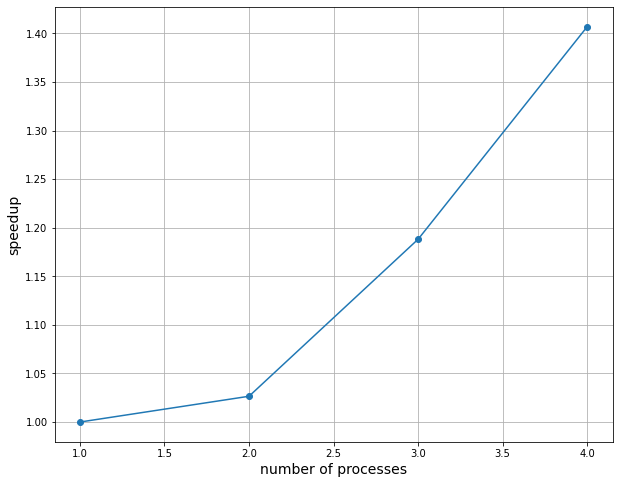

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(nn, speed_up, '-o', alpha=2.)

plt.xlabel('number of processes', fontsize=14)
plt.ylabel('speedup', fontsize=14)

plt.grid()
plt.show()

# 5. Plot Error for Different Discretization

In [17]:
n_processes = 4
nn = np.logspace(1, 5, base=10, num=5).astype(np.int)

for n_steps in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-7.py {int(n_steps)}

In [18]:
error_history = []

for n_steps in nn:
    with open(f'values-{n_processes}-{n_steps}.pkl', 'rb') as f:
        actual_value, result = pickle.load(f)
        error = np.abs(actual_value - result)
    error_history.append(error)

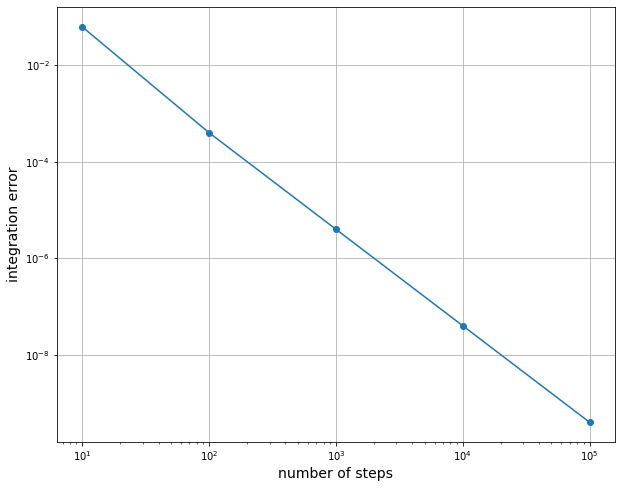

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(nn, error_history, '-o')

plt.xlabel('number of steps', fontsize=14)
plt.ylabel('integration error', fontsize=14)

plt.yscale('log', basey=10)
plt.xscale('log', basex=10)
plt.grid()
plt.show()